### Let's begin by importing useful modules and configuring this Jupyter notebook to display all rows and columns of a dataframe.

In [1]:
import requests
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

### These are some of the available API's that we can retrieve football data from. The English Premier League (EPL) hosts a Fantasy API and we will be using this for the 2018/2019 and 2019/2020 seasons. Note that I already have this data saved on my computer as .json files, so I put the path to those files here.

In [2]:
# Main API: https://fantasy.premierleague.com/api/bootstrap-static/
# Other API: https://api.football-data.org/v2/competitions
api_18_19 = 'season_18_19/season_18_19.json'
api_19_20 = 'season_19_20/season_19_20.json'

### Let's define a function that will perform the API call and return the football data that we are after with .json formatting. Some API's require that you have an API-key to access their data. If this is the case, such as with the *api_other* link, you will need to request one and save the API-key in a local file called *secrets.yml*. This file should be placed in the same working directory as this notebook before calling this function.

In [3]:
def get_api_json(api_url, api_code=False, print_keys=True):
    
    headers = {
        'Accept': "*/*",
        'Cache-Control': "no-cache",
        'accept-encoding': "gzip, deflate",
        'Connection': "keep-alive",
        'cache-control': "no-cache"
        }
    
    if api_code:
        import yaml
        with open("secrets.yml", 'r') as f:
            try: api_code = yaml.safe_load(f)
            except yaml.YAMLError as exc: print(exc)
        headers['X-Auth-Token'] = api_code
        print(api_code)

    response = requests.request("GET", api_url, headers=headers)
    response_json = response.json()
    if print_keys: print(response_json.keys())
    
    return response_json

### Since I already have the data, I define a similar function which reads in a local .json file rather than requesting one from a server.

In [4]:
def get_local_json(json_file, encoding="utf8", print_keys=True):
    with open(json_file, 'r', encoding=encoding) as f:
        json_out = json.load(f)
    if print_keys: print(json_out.keys())
    
    return json_out

### Load the .json file using the local function.

In [5]:
#json_file = get_local_json(api_18_19)
json_file = get_local_json(api_19_20)

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])


### Because .json files are formatted in the form of nested dictionaries, we can use pandas to create dataframes from these dictionaries directly. We make a function that creates separate dataframes for player data, team data, gameweek data, monthly schedules, and positional data. 

In [6]:
def get_season_info(json_file):
    players = pd.DataFrame.from_dict(json_file['elements'])
    teams = pd.DataFrame.from_dict(json_file['teams'])
    gmwks = pd.DataFrame.from_dict(json_file['events'])
    months = pd.DataFrame.from_dict(json_file['phases'])
    positions = pd.DataFrame.from_dict(json_file['element_types'])
    
    return players, teams, gmwks, months, positions

In [7]:
players, teams, gmwks, months, positions = get_season_info(json_file=json_file)

### For reference, let's have a quick look at what is contained in our players dataframe for the season. We can see that there are over 600 players this season and, at least for the columns we are interested in, the player data does not require further cleaning.

In [8]:
players.head()

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type
0,100.0,100.0,69140,0,0,-4,4,0,2,0.0,0.0,0,Shkodran,0.0,1,False,,2020-02-27T23:00:18.104137Z,51,69140.jpg,3.2,Mustafi,0.4,False,None,a,1,3,26,15418,6,38422,9,0.0,5.1,Mustafi,620,0,2,2,9,0,0,0,0,0,0,1,144,174.2,15.4,107.0,29.8,289,113,383,141,246,68,330,117
1,100.0,100.0,98745,0,0,0,0,0,2,0.0,0.0,0,Héctor,0.0,2,False,,2019-12-09T20:00:21.228098Z,55,98745.jpg,3.1,Bellerín,1.2,False,None,a,1,3,25,141114,49,74297,125,0.0,4.5,Bellerín,623,1,0,2,10,0,0,0,2,0,0,3,116,117.6,37.7,38.0,19.5,328,129,329,112,338,118,366,132
2,100.0,100.0,111457,0,0,-3,3,0,2,0.0,0.0,0,Sead,0.0,3,False,,2020-02-23T18:30:13.672943Z,52,111457.jpg,2.1,Kolasinac,0.5,False,None,a,1,3,35,55476,1,127776,2,0.0,6.7,Kolasinac,1103,0,2,2,19,0,0,0,3,0,0,1,222,190.0,157.3,67.0,41.2,279,110,195,47,294,93,289,101
3,100.0,100.0,154043,0,0,-5,5,1,2,0.0,0.0,0,Ainsley,0.0,4,False,,2019-09-22T18:00:10.824841Z,45,154043.jpg,2.6,Maitland-Niles,2.3,False,None,a,1,3,36,591961,10,629865,18,0.0,8.0,Maitland-Niles,1210,0,2,3,19,0,0,0,3,1,0,3,216,261.8,155.4,37.0,44.9,225,89,199,48,339,119,271,89
4,100.0,100.0,39476,0,0,-2,2,1,2,0.0,0.0,0,Sokratis,0.0,5,False,,2020-02-21T01:30:19.929771Z,48,39476.jpg,3.0,Papastathopoulos,1.4,False,None,a,1,3,57,152283,19,194080,22,0.0,11.9,Sokratis,1696,2,0,4,25,0,0,0,6,0,0,5,305,436.2,36.8,110.0,58.5,105,37,331,113,241,65,214,62


In [9]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 61 columns):
chance_of_playing_next_round    481 non-null float64
chance_of_playing_this_round    481 non-null float64
code                            628 non-null int64
cost_change_event               628 non-null int64
cost_change_event_fall          628 non-null int64
cost_change_start               628 non-null int64
cost_change_start_fall          628 non-null int64
dreamteam_count                 628 non-null int64
element_type                    628 non-null int64
ep_next                         628 non-null object
ep_this                         628 non-null object
event_points                    628 non-null int64
first_name                      628 non-null object
form                            628 non-null object
id                              628 non-null int64
in_dreamteam                    628 non-null bool
news                            628 non-null object
news_added          

### Let's use the player dataframe to get a better understanding of how the Premier League teams performed during the season. We will create a new dataframe which contains total fantasy points, total player costs, and return on investment (ROI) per team. The ROI is defined as the number of fantasy points earned per million £ (total fantasy points / total player costs).

In [10]:
total_points_byteam = players.groupby('team')['total_points'].sum().reset_index(drop=True)
players['now_cost'] = players['now_cost']/10  # convert to fantasy prices in millions
total_cost_byteam = players.groupby('team')['now_cost'].sum().reset_index(drop=True)
team_roi = total_points_byteam/total_cost_byteam
team_df = pd.concat([teams['id'], teams['name'], total_points_byteam, total_cost_byteam, team_roi], 
                    axis=1, keys=['id', 'name', 'total_points', 'total_cost', 'team_roi'])
team_df = team_df.sort_values(['team_roi'], ascending=False).reset_index(drop=True)

In [11]:
team_df

,id,name,total_points,total_cost,team_roi
0,9,Leicester,1465,145.7,10.054907
1,10,Liverpool,1631,181.2,9.001104
2,5,Burnley,1148,132.6,8.657617
3,11,Man City,1407,164.1,8.574040
4,15,Sheffield Utd,1212,146.2,8.290014
5,20,Wolves,1207,147.7,8.171970
6,6,Chelsea,1247,163.6,7.622249
7,7,Crystal Palace,1110,150.0,7.400000
8,18,Watford,1051,148.1,7.096556
9,4,Brighton,1051,152.1,6.909928


### A plot of the team ROI will help us visualize which Premier League teams are investing well (at least in the fantasy football domain). We can sort these from largest to smallest and see a correlation with their place in the Premier League table (in the real world domain).

In [12]:
def my_barplot(df, xcol, ycol, xlabel, ylabel):
    fig, ax = plt.subplots(1, 1, figsize = (6, 6), dpi=100)
    g = sns.barplot(x=xcol, y=ycol, data=df, color='steelblue')
    for item in g.get_xticklabels():
        item.set_rotation(90)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

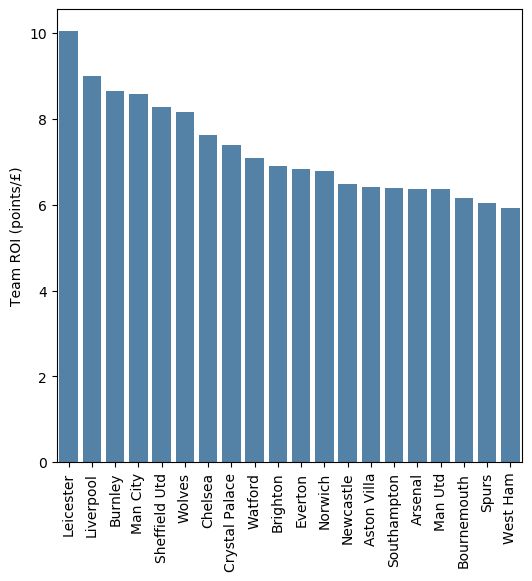

In [13]:
my_barplot(team_df, xcol='name', ycol='team_roi', xlabel='', ylabel='Team ROI (points/£)')

### If you are familiar with competitive football, you may be aware that teams often do not use all of their players. Some players may not play the entire season and others may only play as substitutes for a few minutes at the end of matches. For this reason, we can get a better gauge of a team's fantasy league performance if we normalize the ROI by the number of "main" players in their team. This will disregard the fantasy points and costs related to players who rarely play and instead focus on players who play on average 10 minutes per game.

In [14]:
minutes_threshold = 380

In [15]:
players_main = players[players['minutes'] > minutes_threshold]
players_main = players_main[['first_name', 'second_name', 'team', 'team_code', 'now_cost', 'total_points', 'minutes', 'element_type']]

In [16]:
team_df['players_main'] = players_main.groupby('team')['minutes'].count().reset_index(drop=True)
team_df['team_roi_perplayer'] = team_df['team_roi']/team_df['players_main']
team_df = team_df.sort_values(['team_roi_perplayer'], ascending=False).reset_index(drop=True)

### The team ROI per main player is defined as the number of fantasy points earned per million £ per player who plays more than 380 minutes in a season (total fantasy points / total player costs / number of players who play more than 380 minutes).

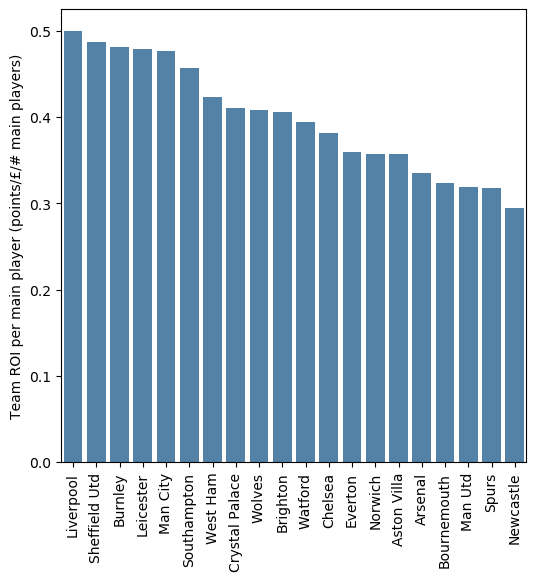

In [17]:
my_barplot(team_df, xcol='name', ycol='team_roi_perplayer', xlabel='', ylabel='Team ROI per main player (points/£/# main players)')

### Now that we have an idea of which teams we should buy from, let's look into the actual players who play more than 380 minutes and score more than 80 fantasy points for the season. We add their personal ROI and the team they play with to the dataframe.

In [18]:
players_main['player_roi'] = players_main['total_points'] / players_main['now_cost']
players_main['team_name'] = players_main['team_code'].map(teams.set_index('code')['name'])
points_thresh = 80
players_main = players_main[players_main['total_points'] > points_thresh]
players_main.head()

,first_name,second_name,team,team_code,now_cost,total_points,minutes,element_type,player_roi,team_name
10,Pierre-Emerick,Aubameyang,1,3,11.1,152,2303,4,13.693694,Arsenal
13,Bernd,Leno,1,3,5.0,108,2520,1,21.600000,Arsenal
25,Nicolas,Pépé,1,3,9.3,88,1587,3,9.462366,Arsenal
41,Jack,Grealish,2,7,6.4,118,2333,3,18.437500,Aston Villa
75,Callum,Wilson,3,91,7.4,95,2346,4,12.837838,Bournemouth


In [19]:
#def get_position(df, pos):
#    #pos is an integer 1-4 corresponding to 1:GK, 2:DEF, 3:MID, 4:FWD
#    pos_df = df[df['element_type']==pos][['first_name', 'second_name', 'team', 'team_name', 'now_cost', 'player_roi']].reset_index(drop=True)
#    return pos_df

### To help make a nice visualization, we incorporate the team ROI per player that we investigated before. This could help in the decision making process by differentiating between players with similar attributes. If all else is the same, a player from a "better" team is preferred.

In [20]:
def get_team_roi_weight(row, magnifier=15):
    team_roi_perplayer = team_df[team_df['id'] == row['team']]['team_roi_perplayer'].iloc[0]
    return team_roi_perplayer*magnifier

In [21]:
players_main['team_roi_weight'] = players_main.apply(lambda row: get_team_roi_weight(row), axis=1)
players_main = players_main.sort_values(['total_points'], ascending=False).reset_index(drop=True)
players_main.head()

,first_name,second_name,team,team_code,now_cost,total_points,minutes,element_type,player_roi,team_name,team_roi_weight
0,Mohamed,Salah,10,14,12.7,186,2243,3,14.645669,Liverpool,7.500920
1,Kevin,De Bruyne,11,43,10.6,178,2148,3,16.792453,Man City,7.145034
2,Sadio,Mané,10,14,12.5,175,2077,3,14.000000,Liverpool,7.500920
3,Jamie,Vardy,9,13,9.7,167,2222,4,17.216495,Leicester,7.182077
4,Trent,Alexander-Arnold,10,14,7.8,166,2549,2,21.282051,Liverpool,7.500920


### Now we can make a scatterplot function so we can customize how everything looks! We want to visualize both the players that produce the most points and the players that are the best value.

In [22]:
from matplotlib.lines import Line2D

def my_scatterplot(df, xcol, ycol, xlabel, ylabel, sizefrom):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1, 1, figsize = (13, 16), dpi=100)
    sns.scatterplot(x=xcol, y=ycol, hue='element_type', data=df, palette='coolwarm', size=df[sizefrom], sizes=(60, 600))
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize = 16)
    cmap = plt.cm.coolwarm
    for line in range(0,df.shape[0]):
        player_color = 'black'
        ax.text(df[xcol][line], df[ycol][line], 
        df.second_name[line], horizontalalignment='left', verticalalignment='top',
        size='small', color=player_color, weight='bold')
    n_positions = len(positions['singular_name_short']) - 1
    custom = [Line2D([], [], marker='.', ms=22, color=cmap(0./n_positions), linestyle='None'),
              Line2D([], [], marker='.', ms=22, color=cmap(1./n_positions), linestyle='None'),
              Line2D([], [], marker='.', ms=22, color=cmap(2./n_positions), linestyle='None'),
              Line2D([], [], marker='.', ms=22, color=cmap(3./n_positions), linestyle='None')]
    ax.legend(custom, positions['singular_name_short'], fontsize=15)
    plt.show()

### Show all players who scored more than 80 fantasy points in the season. Color code them by position and use the circle size to represent the team's strength.

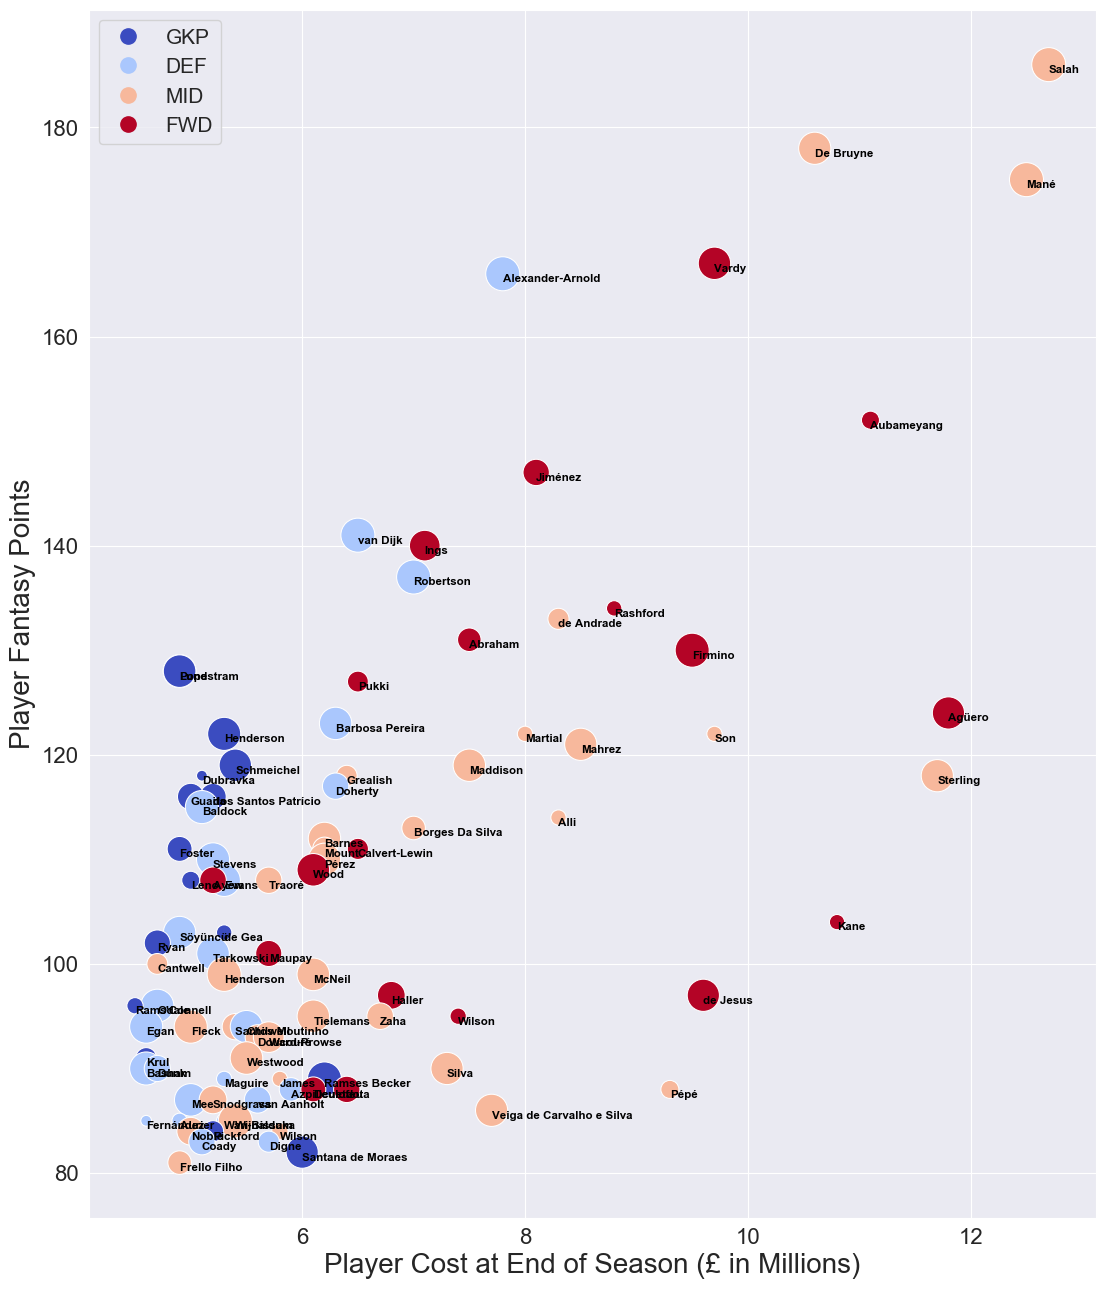

In [23]:
points_thresh = 80
plot_pts=players_main[players_main['total_points'] > points_thresh].reset_index(drop=True)
my_scatterplot(plot_pts, xcol='now_cost', ycol='total_points', xlabel='Player Cost at End of Season (£ in Millions)', ylabel='Player Fantasy Points', sizefrom='team_roi_weight')

### Show all players who have an ROI of 16 or more for the season. Color code them by position and use the circle size to represent the team's strength.

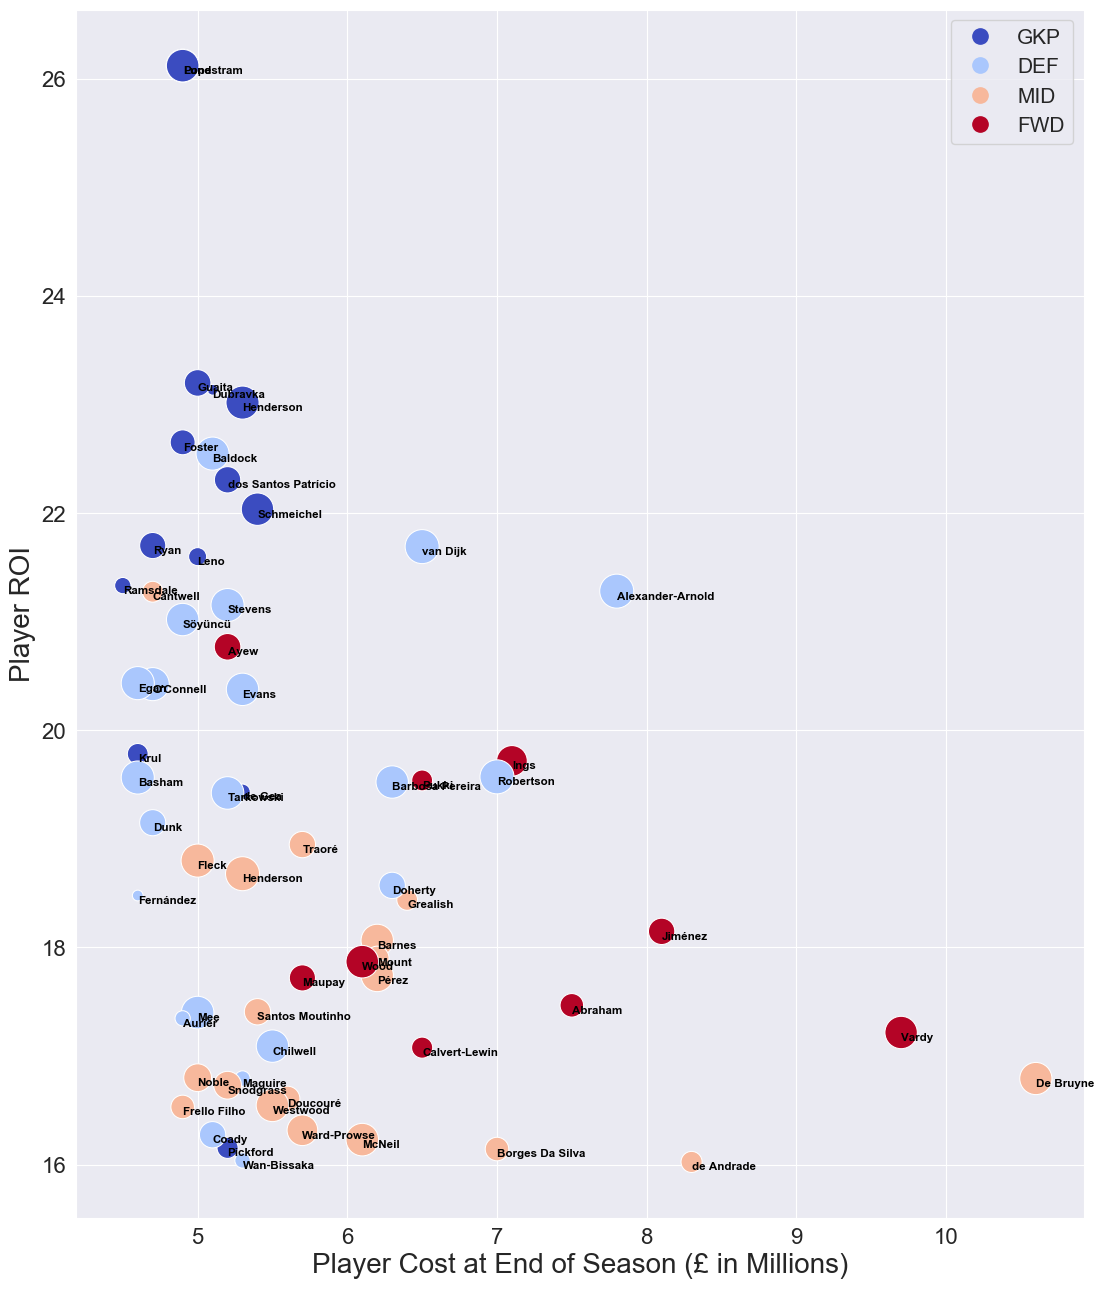

In [24]:
roi_thresh = 16
plot_roi=players_main[players_main['player_roi'] > roi_thresh].reset_index(drop=True)
my_scatterplot(plot_roi, xcol='now_cost', ycol='player_roi', xlabel='Player Cost at End of Season (£ in Millions)', ylabel='Player ROI', sizefrom='team_roi_weight')


In [25]:
# In general we want to have a good mixture of players who have high points and high ROI while keeping within budget.

#TODO: create if-else function which uses fantasy rules to build team with $100 million
#TODO: create pipeline to update recommendation based on injuries
#TODO: consider a ML model for predictions/forecasting (maybe linear regression or random forest)
#TODO: current season cancelled but API might have new types of data next season